In [1]:
# Relevant imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif

In [2]:
# Import train + test datasets and split data
train_data = pd.read_csv('/mnt/c/Users/kpali/Documents/ML/Titanic-Kaggle/train.csv')
test_data = pd.read_csv('/mnt/c/Users/kpali/Documents/ML/Titanic-Kaggle/test.csv')
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)


In [3]:
# Check number of rows
X_train.shape

(712, 11)

In [4]:
# Counts of nulls per column
X_train.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            144
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          547
Embarked         2
dtype: int64

In [5]:
# Drop Cabin column as it doesn't contain enough useful information
X_train = X_train.drop('Cabin', axis=1)

In [6]:
# Checkout missing Embarked values and see if there are passengers with similar name for imputation
print(X_train[X_train['Embarked'].isnull()])
print(X_train[X_train['Name'].str.contains(r'Stone', regex=True)])
print(X_train[X_train['Name'].str.contains(r'Icard', regex=True)])

     PassengerId  Pclass                                       Name     Sex  \
61            62       1                        Icard, Miss. Amelie  female   
829          830       1  Stone, Mrs. George Nelson (Martha Evelyn)  female   

      Age  SibSp  Parch  Ticket  Fare Embarked  
61   38.0      0      0  113572  80.0      NaN  
829  62.0      0      0  113572  80.0      NaN  
     PassengerId  Pclass                                               Name  \
829          830       1          Stone, Mrs. George Nelson (Martha Evelyn)   
319          320       1  Spedden, Mrs. Frederic Oakley (Margaretta Corn...   

        Sex   Age  SibSp  Parch  Ticket   Fare Embarked  
829  female  62.0      0      0  113572   80.0      NaN  
319  female  40.0      1      1   16966  134.5        C  
    PassengerId  Pclass                 Name     Sex   Age  SibSp  Parch  \
61           62       1  Icard, Miss. Amelie  female  38.0      0      0   

    Ticket  Fare Embarked  
61  113572  80.0      

In [7]:
# Drop null values for X_train and y_train 
null_embarked_indexes = X_train[X_train['Embarked'].isnull()].index.tolist()
X_train = X_train.drop(null_embarked_indexes)
y_train = y_train.drop(null_embarked_indexes)


count    566.000000
mean      30.096148
std       14.818458
min        0.420000
25%       20.000000
50%       29.000000
75%       39.000000
max       80.000000
Name: Age, dtype: float64


<Axes: title={'center': 'Histogram of Age'}, xlabel='Age', ylabel='Frequency'>

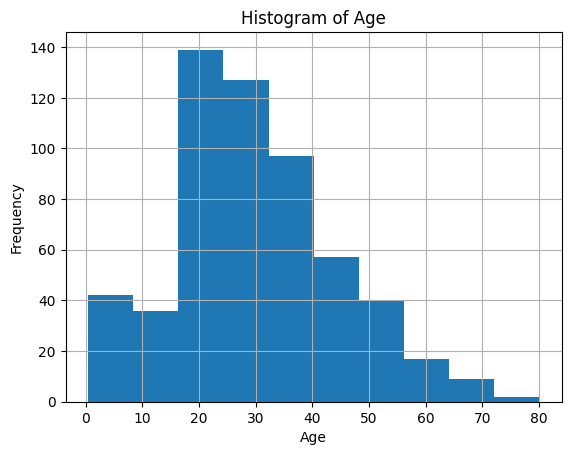

In [8]:
# Age Distribution
print(X_train['Age'].describe())
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
X_train['Age'].hist()

In [9]:
# Impute age
mean_imputation = SimpleImputer(strategy='mean')
age_imputed = mean_imputation.fit_transform(X_train[['Age']])
X_train['Age'] = age_imputed

In [10]:
X_train.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

In [11]:
# Compute mutual information score
def calc_mi_scores(X:pd.DataFrame,y:pd.Series):
    le = LabelEncoder()
    X_mi = X.copy()
    for col in X_mi.select_dtypes("object").columns:
        X_mi[col] = le.fit_transform(X_mi[col])
    mi_scores = mutual_info_classif(X_mi,y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_mi.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

calc_mi_scores(X_train, y_train)

Sex            0.152417
Fare           0.120388
Ticket         0.096601
Pclass         0.080500
Age            0.034469
SibSp          0.030919
Parch          0.012450
Embarked       0.003873
Name           0.002732
PassengerId    0.000000
Name: MI Scores, dtype: float64

In [12]:
# Dropping unimportant features
X_train = X_train.drop(['Name', 'PassengerId', 'Embarked'], axis=1)

In [13]:
# Merge predictors and target into single dataframe
merged_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
merged_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Survived
301,3,male,30.096148,2,0,367226,23.2500,1
309,1,female,30.000000,0,0,PC 17485,56.9292,1
516,2,female,34.000000,0,0,C.A. 34260,10.5000,1
120,2,male,21.000000,2,0,S.O.C. 14879,73.5000,0
570,2,male,62.000000,0,0,S.W./PP 752,10.5000,1


In [14]:
# Generate frequency plot
def generate_frequency_plot(column_name:str):
    frequency = X_train[column_name].value_counts()
    plt.title(f'Frequency by {column_name}')
    plt.xlabel(f'{column_name}')
    plt.ylabel('Frequency')
    frequency.plot(kind='bar')

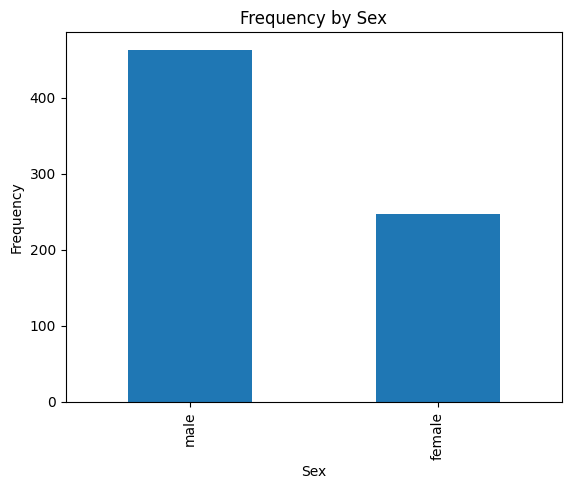

In [15]:
# Exploring Sex
generate_frequency_plot('Sex')

In [16]:
# Calculate survival rates by gender
survival_rate_male = 100.00 * (merged_train[merged_train['Sex'].isin(['male']) & merged_train['Survived'] == 1].shape[0] / merged_train[merged_train['Sex'].isin(['male'])].shape[0])
survival_rate_female = 100.00 * (merged_train[merged_train['Sex'].isin(['female']) & merged_train['Survived'] == 1].shape[0] / merged_train[merged_train['Sex'].isin(['female'])].shape[0])
print('Male survival rate: ', survival_rate_male)
print('Female survival rate', survival_rate_female)

Male survival rate:  18.3585313174946
Female survival rate 73.68421052631578


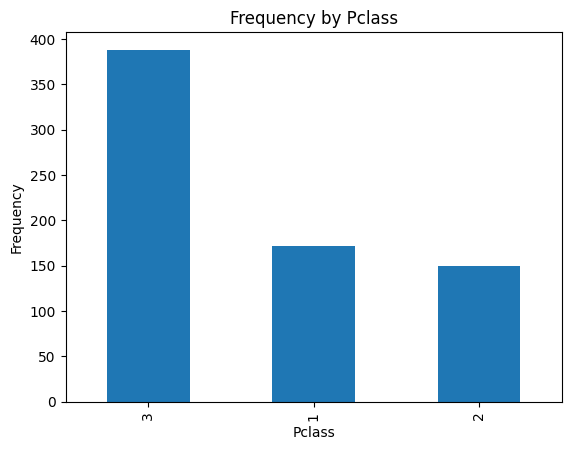

In [17]:
# Exploring Pclass
generate_frequency_plot('Pclass')

In [18]:
# Survival rate by within Pclass + aggregate
survival_rate_by_pclass = merged_train.groupby(['Pclass'])['Survived'].agg(['sum','count']).reset_index()
survival_rate_by_pclass['Survived_Percentage_Pclass'] = 100.00 * (survival_rate_by_pclass['sum'] / survival_rate_by_pclass['count'])
survival_rate_by_pclass['Survived_Percentage_Overall'] = 100.00 * (survival_rate_by_pclass['sum'] / survival_rate_by_pclass['sum'].sum())
survival_rate_by_pclass.head()

,Pclass,sum,count,Survived_Percentage_Pclass,Survived_Percentage_Overall
0,1,107,172,62.209302,40.074906
1,2,73,150,48.666667,27.340824
2,3,87,388,22.422680,32.584270


In [19]:
# Survival rate in Pclass by sex
survival_rate_by_pclass_sex = merged_train.groupby(['Pclass','Sex'])['Survived'].agg(['sum','count']).reset_index()
survival_rate_by_pclass_sex['Survived_Percentage_Pclass'] = 100.00 * (survival_rate_by_pclass_sex['sum'] / survival_rate_by_pclass_sex['count'])
survival_rate_by_pclass_sex['Survived_Percentage_Overall'] = 100.00 * (survival_rate_by_pclass_sex['sum'] / survival_rate_by_pclass_sex['count'].sum())
survival_rate_by_pclass_sex.head()

,Pclass,Sex,sum,count,Survived_Percentage_Pclass,Survived_Percentage_Overall
0,1,female,72,74,97.297297,10.140845
1,1,male,35,98,35.714286,4.929577
2,2,female,58,63,92.063492,8.169014
3,2,male,15,87,17.241379,2.112676
4,3,female,52,110,47.272727,7.323944


In [20]:
merged_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Survived
301,3,male,30.096148,2,0,367226,23.2500,1
309,1,female,30.000000,0,0,PC 17485,56.9292,1
516,2,female,34.000000,0,0,C.A. 34260,10.5000,1
120,2,male,21.000000,2,0,S.O.C. 14879,73.5000,0
570,2,male,62.000000,0,0,S.W./PP 752,10.5000,1


In [21]:
# Generate countplot based on column bins
def countplot_with_bins(bins:list, labels:list, column:str):
    merged_train[f'{column}_Bin'] = pd.cut(merged_train[f'{column}'], bins=bins, labels=labels, include_lowest=True)
    survived = merged_train[merged_train['Survived'] == 1]
    plt.title(f'Survival by {column}_Bin')
    plt.xlabel(f'{column}_Bin')
    plt.ylabel('Percent')
    sns.countplot(data=survived, x=f'{column}_Bin', hue='Survived', stat='percent')

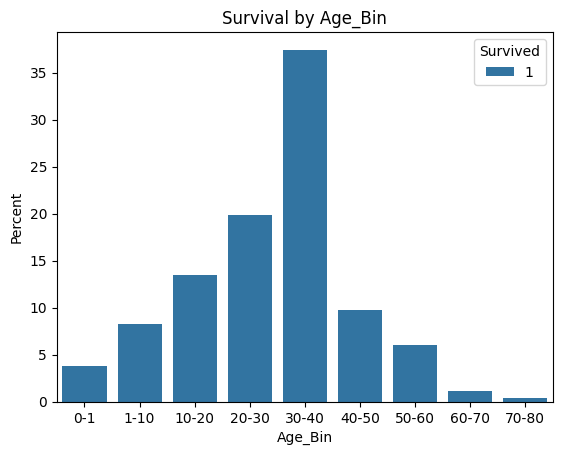

In [22]:
# Survival rate by age group
bins = [0,1,10,20,30,40,50,60,70,80]
labels = ['0-1', '1-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80']
countplot_with_bins(bins=bins, labels=labels, column='Age')

In [23]:
# Exploring SibSp
merged_train['SibSp'].value_counts()

SibSp
0    481
1    176
2     21
3     13
4     12
8      4
5      3
Name: count, dtype: int64

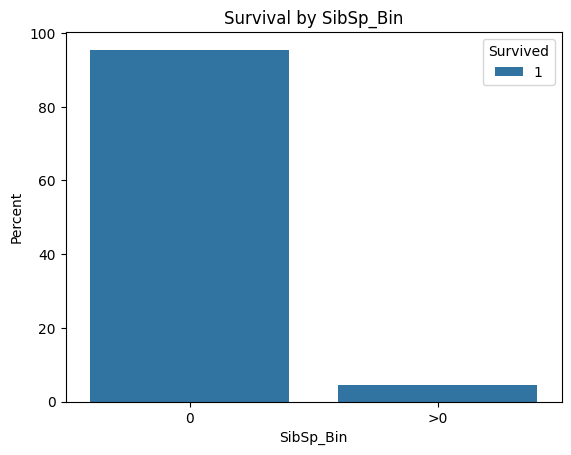

In [24]:
# Survival rate number of siblings 0 vs not 0
bins = [0,1, float('inf')]
labels = ['0', '>0']
countplot_with_bins(bins=bins, labels=labels, column='SibSp')

In [25]:
# Exploring Parch
merged_train['Parch'].value_counts()

Parch
0    539
1    100
2     60
3      4
4      4
5      2
6      1
Name: count, dtype: int64

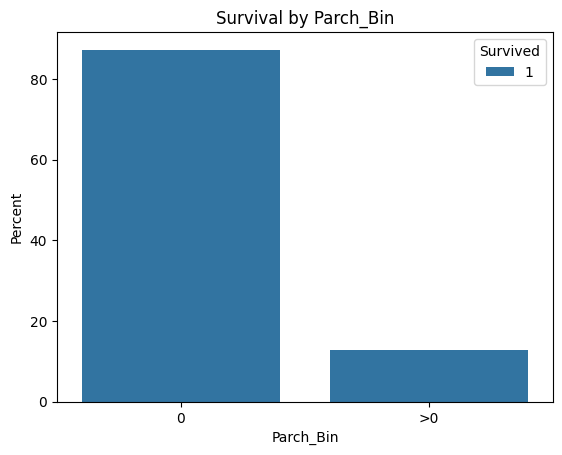

In [26]:
# Survival rate number of Parch 0 vs not 0
bins = [0,1, float('inf')]
labels = ['0', '>0']
countplot_with_bins(bins=bins, labels=labels, column='Parch')

In [27]:
# Exploring Ticket values for survivors
survived = merged_train[merged_train['Survived'] == 1]
survived_ticket_counts = survived['Ticket'].value_counts()
survived_ticket_counts_greater_than_one = survived_ticket_counts[survived_ticket_counts > 1]
df = pd.DataFrame({'Ticket': survived_ticket_counts_greater_than_one.index,
'Count': survived_ticket_counts_greater_than_one.values})
df.head(100)


,Ticket,Count
0,PC 17757,3
1,17421,3
2,113760,3
3,24160,3
4,13502,3
5,363291,2
6,29106,2
7,12749,2
8,C.A. 31921,2
9,17474,2


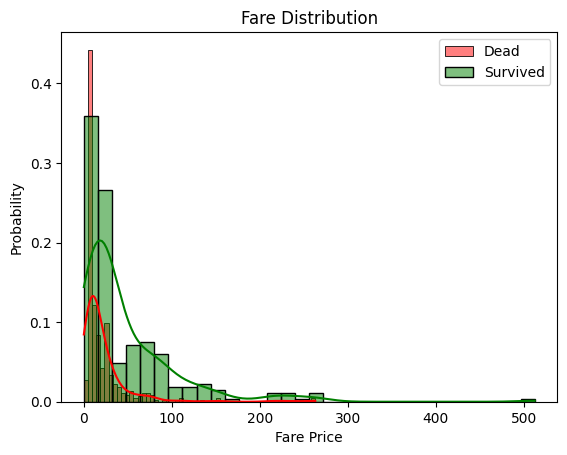

In [28]:
# Exploring fare prices
dead = merged_train[merged_train['Survived'] == 0]
survived = merged_train[merged_train['Survived'] == 1]
plt.title('Fare Distribution')
plt.xlabel('Fare Price')
plt.ylabel('Probability')
sns.histplot(dead['Fare'], color='red', label='Dead', kde=True, stat='probability')
sns.histplot(survived['Fare'], color='green', label='Survived', kde=True, stat='probability')
plt.legend()

In [29]:
# Summary Statistics for fare prices
print('Dead', dead['Fare'].describe(), sep='\n')
print('Survived', survived['Fare'].describe(), sep='\n')

Dead
count    443.000000
mean      22.216712
std       32.863106
min        0.000000
25%        7.841700
50%       10.500000
75%       26.000000
max      263.000000
Name: Fare, dtype: float64
Survived
count    267.000000
mean      47.743493
std       59.273287
min        0.000000
25%       12.475000
50%       26.000000
75%       65.000000
max      512.329200
Name: Fare, dtype: float64


Text(0, 0.5, 'Fare')

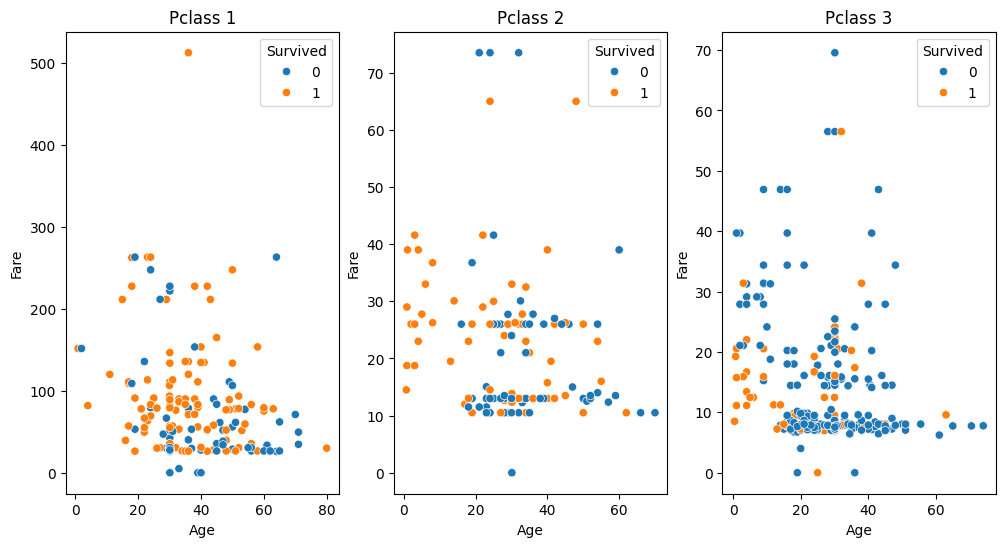

In [30]:
# Age vs Fare price by Pclass dead + survived
fig,axes = plt.subplots(1,3, figsize=(12,6))
sns.scatterplot(data=merged_train[merged_train['Pclass'] == 1], x='Age', y='Fare', hue='Survived', ax=axes[0])
axes[0].set_title('Pclass 1')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Fare')
sns.scatterplot(data=merged_train[merged_train['Pclass'] == 2], x='Age', y='Fare', hue='Survived', ax=axes[1])
axes[1].set_title('Pclass 2')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Fare')
sns.scatterplot(data=merged_train[merged_train['Pclass'] == 3], x='Age', y='Fare', hue='Survived', ax=axes[2])
axes[2].set_title('Pclass 3')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Fare')

<Axes: title={'center': 'Average Fare by Pclass with hue for Sex'}, xlabel='Pclass', ylabel='Average Fare'>

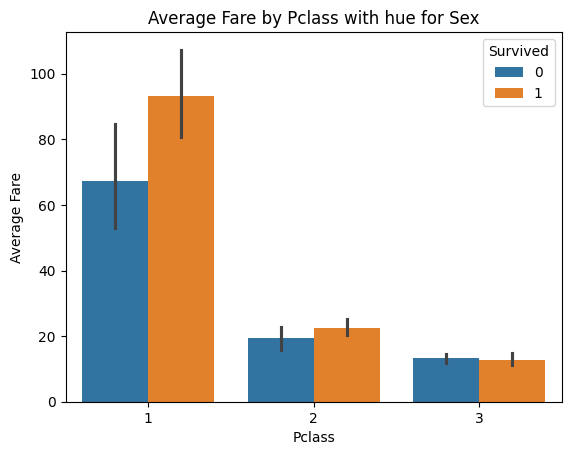

In [31]:
# Average fare price by Pclass
plt.title('Average Fare by Pclass with hue for Sex')
plt.xlabel('Pclass')
plt.ylabel('Average Fare')
sns.barplot(merged_train, x='Pclass', y='Fare', hue='Survived', estimator='mean')

In [32]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare
301,3,male,30.096148,2,0,367226,23.2500
309,1,female,30.000000,0,0,PC 17485,56.9292
516,2,female,34.000000,0,0,C.A. 34260,10.5000
120,2,male,21.000000,2,0,S.O.C. 14879,73.5000
570,2,male,62.000000,0,0,S.W./PP 752,10.5000
